In [ ]:
#!pip install pandas numpy matplotlib seaborn  scikit-learn

In [ ]:
!pip install mplsoccer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.4/86.4 kB 2.4 MB/s eta 0:00:00


In [ ]:
!pip install statsbombpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 1.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from statsbombpy import sb  # Main module for fetching data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch  # For pitch visualizations
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss, classification_report
import time

In [ ]:
competitions = sb.competitions()
print(competitions.head())  # Preview first few
print(competitions.shape)   # How many comps?
print(competitions.columns) # What info per comp?

   competition_id  season_id country_name        competition_name  \
0               9        281      Germany           1. Bundesliga   
1               9         27      Germany           1. Bundesliga   
2            1267        107       Africa  African Cup of Nations   
3              16          4       Europe        Champions League   
4              16          1       Europe        Champions League   

  competition_gender  competition_youth  competition_international  \
0               male              False                      False   
1               male              False                      False   
2               male              False                       True   
3               male              False                      False   
4               male              False                      False   

  season_name               match_updated           match_updated_360  \
0   2023/2024  2024-09-28T20:46:38.893391  2025-07-06T04:26:07.636270   
1   2015/2016  202

In [ ]:
# Explore unique values
print(competitions['competition_gender'].unique())  # Genders available
print(competitions['competition_name'].unique())  # List of comp names
print(competitions.groupby('competition_gender').size())  # Count per gender

['male' 'female']
['1. Bundesliga' 'African Cup of Nations' 'Champions League'
 'Copa America' 'Copa del Rey' "FA Women's Super League"
 'FIFA U20 World Cup' 'FIFA World Cup' 'Indian Super league' 'La Liga'
 'Liga Profesional' 'Ligue 1' 'Major League Soccer'
 'North American League' 'NWSL' 'Premier League' 'Serie A' 'UEFA Euro'
 'UEFA Europa League' "UEFA Women's Euro" "Women's World Cup"]
competition_gender
female     8
male      67
dtype: int64


In [ ]:
womens_comps = competitions[competitions['competition_gender'] == 'female']
print(womens_comps[['competition_id', 'season_id', 'competition_name', 'season_name']])  # Key details
print(womens_comps.shape)  # How many women's comp/seasons

    competition_id  season_id         competition_name season_name
25              37         90  FA Women's Super League   2020/2021
26              37         42  FA Women's Super League   2019/2020
27              37          4  FA Women's Super League   2018/2019
63              49          3                     NWSL        2018
71              53        315        UEFA Women's Euro        2025
72              53        106        UEFA Women's Euro        2022
73              72        107        Women's World Cup        2023
74              72         30        Women's World Cup        2019
(8, 12)


In [ ]:
# Get matches for a specific women's comp/season (e.g., Women's World Cup 2023)
comp_id = 72  # Change as needed
season_id = 107
matches = sb.matches(competition_id=comp_id, season_id=season_id)
print(matches.head())  # Preview
print(matches.shape)   # How many matches?
print(matches.columns) # Info like teams, scores, date

   match_id  match_date      kick_off                        competition  \
0   3904629  2023-08-16  13:00:00.000  International - Women's World Cup   
1   3906390  2023-08-20  13:00:00.000  International - Women's World Cup   
2   3906389  2023-08-19  11:00:00.000  International - Women's World Cup   
3   3904628  2023-08-15  11:00:00.000  International - Women's World Cup   
4   3893806  2023-07-26  10:30:00.000  International - Women's World Cup   

  season          home_team          away_team  home_score  away_score  \
0   2023  Australia Women's    England Women's           1           3   
1   2023      Spain Women's    England Women's           1           0   
2   2023     Sweden Women's  Australia Women's           2           0   
3   2023      Spain Women's     Sweden Women's           2           1   
4   2023      Spain Women's     Zambia Women's           5           0   

  match_status  ...            last_updated_360 match_week competition_stage  \
0    available  ..

In [ ]:
# Get events for one match (pick a match_id from above, e.g., first one)
match_id = matches['match_id'].iloc[0]  # First match
events = sb.events(match_id=match_id)
print(events.head())  # Preview
print(events.shape)   # How many events per match?
print(events['type'].value_counts())  # Common event types (e.g., Pass, Shot)

  50_50 bad_behaviour_card ball_receipt_outcome  \
0   NaN                NaN                  NaN   
1   NaN                NaN                  NaN   
2   NaN                NaN                  NaN   
3   NaN                NaN                  NaN   
4   NaN                NaN                  NaN   

  ball_recovery_recovery_failure block_deflection carry_end_location  \
0                            NaN              NaN                NaN   
1                            NaN              NaN                NaN   
2                            NaN              NaN                NaN   
3                            NaN              NaN                NaN   
4                            NaN              NaN                NaN   

  clearance_aerial_won clearance_body_part clearance_head clearance_left_foot  \
0                  NaN                 NaN            NaN                 NaN   
1                  NaN                 NaN            NaN                 NaN   
2                

In [ ]:
# Filter shots from one match's events
shots = events[events['type'] == 'Shot']
print(shots.head())  # What does a shot look like?
print(shots.columns) # Shot-specific columns (e.g., location, outcome, body_part)

     50_50 bad_behaviour_card ball_receipt_outcome  \
3072   NaN                NaN                  NaN   
3073   NaN                NaN                  NaN   
3074   NaN                NaN                  NaN   
3075   NaN                NaN                  NaN   
3076   NaN                NaN                  NaN   

     ball_recovery_recovery_failure block_deflection carry_end_location  \
3072                            NaN              NaN                NaN   
3073                            NaN              NaN                NaN   
3074                            NaN              NaN                NaN   
3075                            NaN              NaN                NaN   
3076                            NaN              NaN                NaN   

     clearance_aerial_won clearance_body_part clearance_head  \
3072                  NaN                 NaN            NaN   
3073                  NaN                 NaN            NaN   
3074                  NaN       

In [ ]:
# Function to fetch shots for all omen competitions
def fetch_womens_shots(comp_list):
    all_shots = []
    for _, comp in comp_list.iterrows():
        comp_id = comp['competition_id']
        season_id = comp['season_id']
        try:
            matches = sb.matches(competition_id=comp_id, season_id=season_id)
            print(f"Fetching {matches.shape[0]} matches for {comp['competition_name']} {comp['season_name']}...")
            for match_id in matches['match_id']:
                events = sb.events(match_id=match_id)
                shots = events[events['type'] == 'Shot'].copy()  # Explicit copy to avoid warning
                if not shots.empty:
                    shots.loc[:, 'competition_name'] = comp['competition_name']  # Use .loc for assignment
                    shots.loc[:, 'season_name'] = comp['season_name']
                    all_shots.append(shots)
                time.sleep(0.5)  # API politeness
        except Exception as e:
            print(f"Error for comp {comp_id}, season {season_id}: {e}")
    return pd.concat(all_shots, ignore_index=True) if all_shots else pd.DataFrame()

# Fetch shots for a subset of women's comps (e.g., first 2 to test)
subset_comps = womens_comps.head(2)  # Adjust to full list later
df_shots = fetch_womens_shots(subset_comps)
print(f"Total shots fetched: {df_shots.shape[0]}")
print(df_shots[['minute', 'second', 'location', 'shot_body_part', 'shot_type', 'shot_outcome']].head())

# Save to CSV
df_shots.to_csv('womens_shots_statsbomb.csv', index=False)

Fetching 131 matches for FA Women's Super League 2020/2021...


KeyboardInterrupt: 

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Save CSV to Google Drive (e.g., in 'My Drive' folder)
df_shots.to_csv('/content/drive/My Drive/Stevens Analytics/Soccer/womens_shots_statsbomb.csv', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


KeyboardInterrupt: 

In [ ]:
# Load from Google Drive (if saved there)
df_shots = pd.read_csv('/content/drive/My Drive/Stevens Analytics/Soccer/womens_shots_statsbomb.csv')
print(df_shots.shape)
print(df_shots.head())

(1918, 119)
   50_50  ball_receipt_outcome  ball_recovery_recovery_failure  \
0    NaN                   NaN                             NaN   
1    NaN                   NaN                             NaN   
2    NaN                   NaN                             NaN   
3    NaN                   NaN                             NaN   
4    NaN                   NaN                             NaN   

   block_deflection  block_offensive  carry_end_location  \
0               NaN              NaN                 NaN   
1               NaN              NaN                 NaN   
2               NaN              NaN                 NaN   
3               NaN              NaN                 NaN   
4               NaN              NaN                 NaN   

   clearance_aerial_won  clearance_body_part  clearance_head  \
0                   NaN                  NaN             NaN   
1                   NaN                  NaN             NaN   
2                   NaN               

##Cleaning Data/Feature Engineering


In [ ]:

print(f"Total shots: {df_shots.shape[0]}")
print("Columns available:")
print(df_shots.columns.tolist())
print("\nFirst few rows:")
print(df_shots[['minute', 'second', 'location', 'shot_body_part', 'shot_technique',
                'shot_type', 'shot_first_time', 'shot_one_on_one', 'shot_outcome']].head())
print("\nMissing values in key columns:")
print(df_shots[['minute', 'second', 'location', 'shot_body_part', 'shot_technique',
                'shot_type', 'shot_first_time', 'shot_one_on_one', 'shot_outcome']].isna().sum())

Total shots: 1918
Columns available:
['50_50', 'ball_receipt_outcome', 'ball_recovery_recovery_failure', 'block_deflection', 'block_offensive', 'carry_end_location', 'clearance_aerial_won', 'clearance_body_part', 'clearance_head', 'clearance_left_foot', 'clearance_right_foot', 'counterpress', 'dribble_nutmeg', 'dribble_outcome', 'duel_outcome', 'duel_type', 'duration', 'foul_committed_advantage', 'foul_committed_card', 'foul_committed_type', 'foul_won_advantage', 'foul_won_defensive', 'goalkeeper_body_part', 'goalkeeper_end_location', 'goalkeeper_outcome', 'goalkeeper_position', 'goalkeeper_punched_out', 'goalkeeper_technique', 'goalkeeper_type', 'id', 'index', 'interception_outcome', 'location', 'match_id', 'minute', 'off_camera', 'out', 'pass_aerial_won', 'pass_angle', 'pass_assisted_shot_id', 'pass_body_part', 'pass_cross', 'pass_cut_back', 'pass_deflected', 'pass_end_location', 'pass_goal_assist', 'pass_height', 'pass_inswinging', 'pass_length', 'pass_miscommunication', 'pass_no_to

In [ ]:
print(f"Initial shots: {df_shots.shape[0]}")

# Derive location-based features
df_shots['x'] = df_shots['location'].apply(lambda loc: eval(loc)[0] if isinstance(loc, str) else loc[0])
df_shots['y'] = df_shots['location'].apply(lambda loc: eval(loc)[1] if isinstance(loc, str) else loc[1])

# Normalize to 0-100 scale
df_shots['x'] = df_shots['x'] / 1.2
df_shots['y'] = df_shots['y'] / 0.8
goal_x, goal_y = 100, 50

# Derive distance and angle
df_shots['distance'] = np.sqrt((goal_x - df_shots['x'])**2 + (goal_y - df_shots['y'])**2)
df_shots['angle'] = np.degrees(np.arctan2(np.abs(goal_y - df_shots['y']), (goal_x - df_shots['x'])))

# Create is_goal
df_shots['is_goal'] = df_shots['shot_outcome'] == 'Goal'

# Create assisted (fixed: use shot_key_pass_id)
df_shots['assisted'] = df_shots['shot_key_pass_id'].notna()

# Handle missing values
df_shots['first_time'] = df_shots['shot_first_time'].fillna(False)
df_shots['one_on_one'] = df_shots['shot_one_on_one'].fillna(False)

# Drop rows with missing critical features
df_shots.dropna(subset=['x', 'y', 'shot_body_part', 'shot_technique', 'shot_type'], inplace=True)

# Filter out own goals
df_shots = df_shots[df_shots['shot_outcome'] != 'Own Goal']

# Check distributions
print("Shot type counts (proportion):")
print(df_shots['shot_type'].value_counts(normalize=True))
print("\nAssisted check (non-NaN counts):")
print(df_shots[['shot_key_pass_id']].notna().sum())

# Keep desired columns (removed rebound)
keep_cols = ['minute', 'second', 'x', 'y', 'distance', 'angle', 'shot_body_part',
             'shot_technique', 'shot_type', 'assisted', 'first_time', 'one_on_one',
             'is_goal', 'competition_name', 'season_name']
df_shots = df_shots[keep_cols]

# Final checks
print(f"\nCleaned data shape: {df_shots.shape}")
print("\nMissing values after cleaning:")
print(df_shots.isna().sum())
print("\nFeature distributions:")
print(df_shots['shot_body_part'].value_counts(dropna=False))
print(df_shots['shot_technique'].value_counts(dropna=False))
print(df_shots['shot_type'].value_counts(dropna=False))
print(df_shots['assisted'].value_counts(dropna=False))
print(df_shots['first_time'].value_counts(dropna=False))
print(df_shots['one_on_one'].value_counts(dropna=False))
print("\nPreview cleaned data:")
print(df_shots.head())

# Save cleaned data
df_shots.to_csv('womens_shots_cleaned.csv', index=False)

Initial shots: 1918
Shot type counts (proportion):
shot_type
Open Play    0.956204
Free Kick    0.029718
Penalty      0.014077
Name: proportion, dtype: float64

Assisted check (non-NaN counts):
shot_key_pass_id    1306
dtype: int64

Cleaned data shape: (1918, 15)

Missing values after cleaning:
minute              0
second              0
x                   0
y                   0
distance            0
angle               0
shot_body_part      0
shot_technique      0
shot_type           0
assisted            0
first_time          0
one_on_one          0
is_goal             0
competition_name    0
season_name         0
dtype: int64

Feature distributions:
shot_body_part
Right Foot    1115
Left Foot      483
Head           317
Other            3
Name: count, dtype: int64
shot_technique
Normal           1529
Half Volley       246
Volley            114
Backheel           10
Lob                10
Diving Header       7
Overhead Kick       2
Name: count, dtype: int64
shot_type
Open Play    18

/tmp/ipython-input-2130813801.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_shots['first_time'] = df_shots['shot_first_time'].fillna(False)
/tmp/ipython-input-2130813801.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_shots['one_on_one'] = df_shots['shot_one_on_one'].fillna(False)


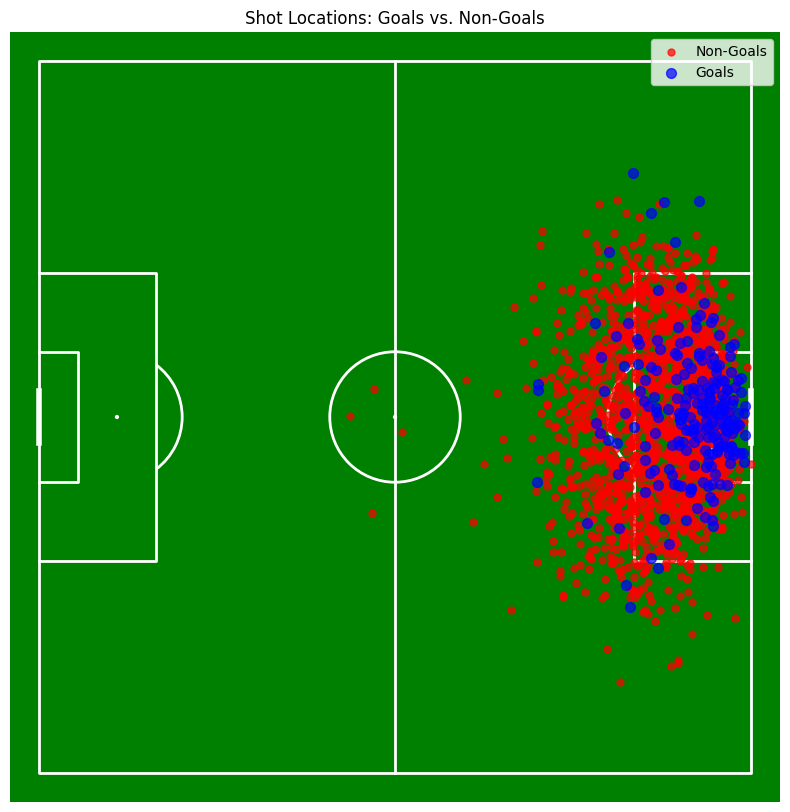

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# Load cleaned data
df_shots = pd.read_csv('womens_shots_cleaned.csv')

# Set up the pitch
pitch = Pitch(pitch_type='custom', pitch_length=100, pitch_width=100, line_color='white', pitch_color='green')
fig, ax = pitch.draw(figsize=(8, 10))

# Scatter plot: goals (blue) and non-goals (red)
goals = df_shots[df_shots['is_goal'] == True]
non_goals = df_shots[df_shots['is_goal'] == False]
pitch.scatter(non_goals['x'], non_goals['y'], ax=ax, c='red', label='Non-Goals', s=25, alpha=0.7)
pitch.scatter(goals['x'], goals['y'], ax=ax, c='blue', label='Goals', s=50, alpha=0.7)

# Add legend and title
plt.legend()
plt.title('Shot Locations: Goals vs. Non-Goals')
plt.show()

### Model Building

In [ ]:
# Load the cleaned CSV
df = pd.read_csv('womens_shots_cleaned.csv')

# Verify shape and columns
print(f"Shape: {df.shape}")
print("Columns:", df.columns.tolist())

# Check data types and non-null counts
print("\nData Info:")
print(df.info())

# Basic stats for numerical features
print("\nNumerical Stats:")
print(df[['distance', 'angle', 'minute', 'second']].describe())

# Check for any missing values
print("\nMissing Values:")
print(df.isna().sum())

# Preview first few rows
print("\nHead:")
print(df.head())

Shape: (1918, 15)
Columns: ['minute', 'second', 'x', 'y', 'distance', 'angle', 'shot_body_part', 'shot_technique', 'shot_type', 'assisted', 'first_time', 'one_on_one', 'is_goal', 'competition_name', 'season_name']

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1918 entries, 0 to 1917
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   minute            1918 non-null   int64  
 1   second            1918 non-null   int64  
 2   x                 1918 non-null   float64
 3   y                 1918 non-null   float64
 4   distance          1918 non-null   float64
 5   angle             1918 non-null   float64
 6   shot_body_part    1918 non-null   object 
 7   shot_technique    1918 non-null   object 
 8   shot_type         1918 non-null   object 
 9   assisted          1918 non-null   bool   
 10  first_time        1918 non-null   bool   
 11  one_on_one        1918 non-null   bool   
 12  is_g

In [ ]:
# Load cleaned data
df = pd.read_csv('womens_shots_cleaned.csv')

# Select model features
model_features = ['distance', 'angle', 'shot_body_part', 'shot_technique', 'assisted', 'first_time', 'one_on_one']
X = df[model_features]
y = df['is_goal'].astype(int)  # Ensure target is 0/1

# One-hot encode categoricals
X = pd.get_dummies(X, columns=['shot_body_part', 'shot_technique'], drop_first=True)

# Check for outliers in numerical features
print("Numerical Feature Stats:")
print(X[['distance', 'angle']].describe())

# Check data types
print("\nX Data Info:")
print(X.info())

# Preview feature matrix and target
print("\nX Head:")
print(X.head())
print("\nX Shape:", X.shape)
print("\ny Head:")
print(y.head())
print("\ny Shape:", y.shape)

# Check target distribution
print("\nTarget Distribution:")
print(y.value_counts(normalize=True))

Numerical Feature Stats:
          distance        angle
count  1918.000000  1918.000000
mean     16.744306    34.469073
std       7.718349    20.417666
min       1.118034     0.000000
25%      10.323562    17.684919
50%      16.266038    34.365239
75%      22.128893    50.725105
max      56.333472    90.000000

X Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1918 entries, 0 to 1917
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   distance                      1918 non-null   float64
 1   angle                         1918 non-null   float64
 2   assisted                      1918 non-null   bool   
 3   first_time                    1918 non-null   bool   
 4   one_on_one                    1918 non-null   bool   
 5   shot_body_part_Left Foot      1918 non-null   bool   
 6   shot_body_part_Other          1918 non-null   bool   
 7   shot_body_part_Right Foot     

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming X and y from previous step
# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check split sizes
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

# Check goal distribution in train/test
print("\nTraining goal distribution:")
print(y_train.value_counts(normalize=True))
print("\nTest goal distribution:")
print(y_test.value_counts(normalize=True))

Training set shape: (1534, 14) (1534,)
Test set shape: (384, 14) (384,)

Training goal distribution:
is_goal
0    0.876141
1    0.123859
Name: proportion, dtype: float64

Test goal distribution:
is_goal
0    0.877604
1    0.122396
Name: proportion, dtype: float64


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss, classification_report

# Assuming X_train, X_test, y_train, y_test from previous step
# Define parameter grid (simplified to avoid convergence issues)
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'max_iter': [100, 500],
    'class_weight': ['balanced', None],
    'solver': ['liblinear']
}

# Set up model and grid search
model = LogisticRegression()
grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)

# Fit model
grid_search.fit(X_train, y_train)

# Results
print("Best Parameters:", grid_search.best_params_)
print("Best ROC AUC (CV):", grid_search.best_score_)

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
print("\nTest ROC AUC:", roc_auc_score(y_test, y_pred_proba))
print("Test Log Loss:", log_loss(y_test, y_pred_proba))
print("Test Brier Score:", brier_score_loss(y_test, y_pred_proba))
print("\nClassification Report:")
print(classification_report(y_test, (y_pred_proba > 0.5).astype(int)))

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Parameters: {'C': 10, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best ROC AUC (CV): 0.7807070962065382

Test ROC AUC: 0.6799040343456026
Test Log Loss: 0.3646184777758699
Test Brier Score: 0.10159493109760398

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       337
           1       0.43      0.06      0.11        47

    accuracy                           0.88       384
   macro avg       0.66      0.53      0.52       384
weighted avg       0.83      0.88      0.83       384



In [ ]:
import pandas as pd
import joblib
from sklearn.linear_model import LogisticRegression

# Load cleaned data
df = pd.read_csv('womens_shots_cleaned.csv')

# Assuming X, y from feature engineering (recreate for model input)
model_features = ['distance', 'angle', 'shot_body_part', 'shot_technique', 'assisted', 'first_time', 'one_on_one']
X = pd.get_dummies(df[model_features], columns=['shot_body_part', 'shot_technique'], drop_first=True)

# Save the trained model (from previous step)
joblib.dump(grid_search.best_estimator_, 'xg_model_womens.pkl')

# Load the model
model = joblib.load('xg_model_womens.pkl')

# Select sample shots (e.g., first goal, first non-goal, a penalty)
sample_indices = [
    df[df['is_goal'] == True].index[0],  # First goal
    df[df['is_goal'] == False].index[0],  # First non-goal
    df[df['is_goal'] == True].index[1],
    df[df['is_goal'] == False].index[1],
    df[df['one_on_one'] == True].index[0],
]

# Predict xG for samples
sample_X = X.loc[sample_indices]
xG = model.predict_proba(sample_X)[:, 1]  # Probability of goal (xG)

# Show full rows and xG
print("Sample Shots with xG:")
sample_df = df.loc[sample_indices].copy()
sample_df['xG'] = xG
print(sample_df[['minute', 'second', 'x', 'y', 'distance', 'angle', 'shot_body_part',
                 'shot_technique', 'shot_type', 'assisted', 'first_time', 'one_on_one',
                 'is_goal', 'xG']])

Sample Shots with xG:
    minute  second          x      y   distance      angle shot_body_part  \
20      57      58  96.583333  49.00   3.560002  16.313852      Left Foot   
0        1      27  83.833333  68.25  24.380804  48.464041      Left Foot   
23      66       4  92.000000  46.50   8.732125  23.629378      Left Foot   
1        5      21  91.166667  53.75   9.596368  23.002597           Head   
29      77      13  98.083333  44.00   6.298699  72.284207           Head   

   shot_technique  shot_type  assisted  first_time  one_on_one  is_goal  \
20    Half Volley  Open Play      True        True       False     True   
0          Normal  Open Play      True       False       False    False   
23         Normal  Open Play     False        True       False     True   
1          Normal  Open Play      True       False       False    False   
29         Normal  Open Play      True       False        True    False   

          xG  
20  0.503322  
0   0.021847  
23  0.449193  
1   

##Apply Model to Stevens Team

This code below actually makes all of the stuff above usable for us at Stevens, essentially we can import a csv file of the shot data from a specific game and get the xG for all of the shots in that game based off of the model we trained.

In [ ]:
import pandas as pd
import numpy as np
import joblib
from google.colab import files

# Load the trained model
model = joblib.load('xg_model_womens.pkl')

# Upload your team's CSV
input_csv = '/content/drive/My Drive/Stevens Analytics/Soccer/STEV_vs_SLC_shot_data.csv'
df_team = pd.read_csv(input_csv)

# Derive distance and angle from x, y (0-100 scale)
goal_x, goal_y = 100, 50
df_team['distance'] = np.sqrt((goal_x - df_team['x'])**2 + (goal_y - df_team['y'])**2)
df_team['angle'] = np.degrees(np.arctan2(np.abs(goal_y - df_team['y']), (goal_x - df_team['x'])))

# Ensure booleans are proper (True/False or 1/0 → bool)
for col in ['assisted', 'first_time', 'one_on_one']:
    if col in df_team.columns:
        df_team[col] = df_team[col].astype(bool)

# Prepare model input (match training features)
model_features = ['distance', 'angle', 'shot_body_part', 'shot_technique', 'assisted', 'first_time', 'one_on_one']
X_team = df_team[model_features]
X_team = pd.get_dummies(X_team, columns=['shot_body_part', 'shot_technique'], drop_first=True)

# Align columns with training X (add missing encoded columns with False)
training_columns = ['distance', 'angle', 'assisted', 'first_time', 'one_on_one',
                    'shot_body_part_Left Foot', 'shot_body_part_Other', 'shot_body_part_Right Foot',
                    'shot_technique_Diving Header', 'shot_technique_Half Volley', 'shot_technique_Lob',
                    'shot_technique_Normal', 'shot_technique_Overhead Kick', 'shot_technique_Volley']
for col in training_columns:
    if col not in X_team.columns:
        X_team[col] = 0  # Fill missing with 0 (False)

X_team = X_team[training_columns]  # Reorder to match training

# Predict xG
df_team['xG'] = model.predict_proba(X_team)[:, 1]

# Save and download output CSV
output_csv = 'STEV_vs_SLC_shot_data_xGoals.csv'
df_team.to_csv(output_csv, index=False)
files.download(output_csv)

# Preview first few rows with xG
print("\nPreview with xG:")
print(df_team[['minute', 'second', 'x', 'y', 'shot_body_part', 'shot_technique', 'assisted', 'first_time', 'one_on_one', 'xG']].head())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Preview with xG:
   minute  second   x   y shot_body_part shot_technique  assisted  first_time  \
0      92      49  92  59     Right Foot         Normal      True        True   
1      48      10  92  57     Right Foot         Normal      True        True   
2     109      21  95  49     Right Foot         Normal     False       False   
3      71      33  92  42     Right Foot         Normal      True       False   
4      34       2  90  42      Left Foot    Half Volley     False        True   

   one_on_one        xG  
0       False  0.200534  
1       False  0.255019  
2       False  0.631245  
3        True  0.213826  
4       False  0.037667  


##Creating Spreadsheet template for data collection


In [ ]:
import pandas as pd
from google.colab import files

# Define template data with all possible shot_body_part, shot_technique, shot_type
template_data = {
    'minute': [14, 25, 45, 60, 75, 88, 90],
    'second': [10, 45, 30, 20, 15, 50, 5],
    'x': [85.0, 92.0, 88.0, 70.0, 80.0, 90.0, 95.0],
    'y': [45.0, 50.0, 55.0, 60.0, 40.0, 48.0, 52.0],
    'shot_body_part': ['Head', 'Right Foot', 'Left Foot', 'Other', 'Right Foot', 'Head', 'Left Foot'],
    'shot_technique': ['Normal', 'Half Volley', 'Volley', 'Lob', 'Backheel', 'Diving Header', 'Overhead Kick'],
    'assisted': [True, True, False, False, True, True, False],
    'first_time': [False, True, False, False, True, False, True],
    'one_on_one': [False, False, True, False, False, True, False],
    'shot_type': ['Open Play', 'Free Kick', 'Penalty', 'Corner', 'Open Play', 'Open Play', 'Free Kick']
}

# Create DataFrame
template_df = pd.DataFrame(template_data)

# Save to CSV and download
template_df.to_csv('team_shots_template.csv', index=False)
files.download('team_shots_template.csv')

# Preview template
print("Template Preview:")
print(template_df)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Template Preview:
   minute  second     x     y shot_body_part shot_technique  assisted  \
0      14      10  85.0  45.0           Head         Normal      True   
1      25      45  92.0  50.0     Right Foot    Half Volley      True   
2      45      30  88.0  55.0      Left Foot         Volley     False   
3      60      20  70.0  60.0          Other            Lob     False   
4      75      15  80.0  40.0     Right Foot       Backheel      True   
5      88      50  90.0  48.0           Head  Diving Header      True   
6      90       5  95.0  52.0      Left Foot  Overhead Kick     False   

   first_time  one_on_one  shot_type  
0       False       False  Open Play  
1        True       False  Free Kick  
2       False        True    Penalty  
3       False       False     Corner  
4        True       False  Open Play  
5       False        True  Open Play  
6        True       False  Free Kick  


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

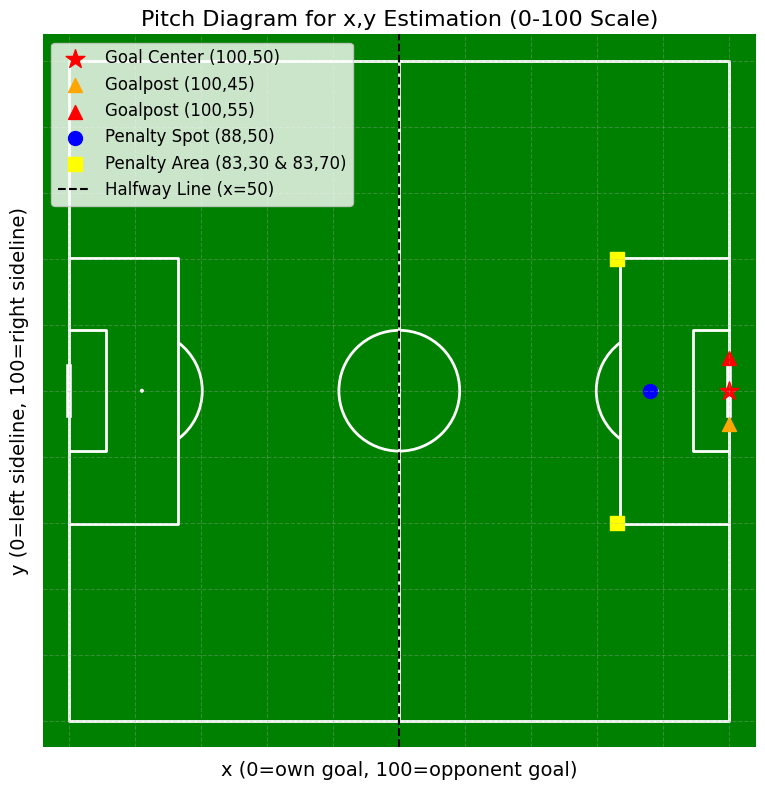

In [ ]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from google.colab import files

# Set up pitch (0-100 x, 0-100 y, goal at 100,50)
pitch = Pitch(pitch_type='custom', pitch_length=100, pitch_width=100, line_color='white', pitch_color='green')
fig, ax = pitch.draw(figsize=(12, 8))

# Add reference points
ax.scatter(100, 50, c='red', s=200, marker='*', label='Goal Center (100,50)')
ax.scatter(100, 45, c='orange', s=100, marker='^', label='Goalpost (100,45)')
ax.scatter(100, 55, c='red', s=100, marker='^', label='Goalpost (100,55)')
ax.scatter(88, 50, c='blue', s=100, marker='o', label='Penalty Spot (88,50)')
ax.scatter(83, 30, c='yellow', s=100, marker='s', label='Penalty Area (83,30 & 83,70)')
ax.scatter(83, 70, c='yellow', s=100, marker='s')
ax.axvline(x=50, c='black', linestyle='--', label='Halfway Line (x=50)')

# Add x and y axes with ticks
ax.set_xticks(range(0, 101, 10))
ax.set_yticks(range(0, 101, 10))
ax.set_xticklabels(range(0, 101, 10), fontsize=12, rotation=0)
ax.set_yticklabels(range(0, 101, 10), fontsize=12)
ax.set_xlabel('x (0=own goal, 100=opponent goal)', fontsize=14, labelpad=10)
ax.set_ylabel('y (0=left sideline, 100=right sideline)', fontsize=14, labelpad=10)

# Force ticks to show
ax.tick_params(axis='both', which='both', length=5, labelsize=12, pad=5)

# Add grid for reference
ax.grid(True, alpha=0.3, linestyle='--')

# Add legend and title
plt.legend(fontsize=12, loc='upper left')
plt.title('Pitch Diagram for x,y Estimation (0-100 Scale)', fontsize=16)
plt.tight_layout()

# Save and download
plt.savefig('pitch_diagram_with_axes.png', bbox_inches='tight', dpi=300)
files.download('pitch_diagram_with_axes.png')
plt.show()